# STTMALST Gastrointestinal-Cancer-MSI-MSS-Prediction

**Project created and conducted by: Christopher Bernold and Ellen Huld Þórðardóttir**

_Fall 2020_

Reference list and inspriation links:<br>

https://www.tensorflow.org/tutorials/load_data/images<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#top_of_page  <br>
https://www.tensorflow.org/tutorials/images/classification<br>


In [3]:
#inspired by https://www.tensorflow.org/tutorials/load_data/images
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib 
import os
import PIL
import PIL.Image
import tensorflow as tf
import datetime
import tensorflow_datasets as tfds
import pathlib
from time import time
from tensorflow.python.client import device_lib
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix


In [4]:
import tensorflow as tf; print(tf.__version__)

2.4.0


In [5]:
#Globals
batch_size = 128
epochs = 15
img_height_resized, img_width_resized = 28,28

Specifying tensorflow to use a GPU but only allocate memory from GPU when needed. 

_Currently broken as tensorflow does not always detect NVIDIA RTX GPU's, searching for solution._

In [6]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())

Tensorflow version:  2.4.0
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6819850117527742853
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4815519744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 674999768432226319
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Setting up the data 

In [7]:
DATA_PATH = './tcga_coad_msi_mss'
data_dir = pathlib.Path(DATA_PATH)

In [8]:
#Gets all images in all dataset folders
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print("Total amount of images is: ", image_count)

Total amount of images is:  192312


In [9]:
train_MSS, train_MSIMUT = list(data_dir.glob('train/MSS/*')), list(data_dir.glob('train/MSIMUT/*'))
test_MSS, test_MSIMUT = list(data_dir.glob('test/MSS/*')), list(data_dir.glob('test/MSIMUT/*'))
val_MSS, val_MSIMUT  = list(data_dir.glob('val/MSS/*')), list(data_dir.glob('val/MSIMUT/*'))

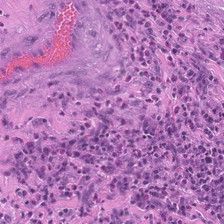

In [10]:
PIL.Image.open(str(train_MSS[0]))

In [11]:
image_details = PIL.Image.open(str(train_MSIMUT[0]))
width, height = image_details.size
print("Width:" , width , ", Height:" , height , ", Batch size:" , batch_size)

Width: 224 , Height: 224 , Batch size: 128


Specifying dataset folder locations. Data is already split up into train test and validation set, <br>
 meaning that we do not need to create a 80/20 split for the training and validation set.

In [12]:
training_set_dir = os.path.join(DATA_PATH, 'train')
training_root = pathlib.Path(training_set_dir)

test_set_dir = os.path.join(DATA_PATH, 'test')
test_root = pathlib.Path(test_set_dir)

validation_set_dir = os.path.join(DATA_PATH,'val')
validation_root = pathlib.Path(validation_set_dir)

train_MSIMUT_dir = os.path.join(training_set_dir, 'MSIMUT')
train_MSS_dir = os.path.join(training_set_dir, 'MSS')

test_MSIMUT_dir = os.path.join(test_set_dir, 'MSIMUT')
test_MSS_dir = os.path.join(test_set_dir, 'MSS')

validation_MSIMUT_dir = os.path.join(validation_set_dir, 'MSIMUT')
validation_MSS_dir = os.path.join(validation_set_dir, 'MSS')

When using categorical data it is wise to use one hot encoding. This is because when working with machine learning,<br>
 algorithms cannot use a labels string value directly, but instead requires all input and output values to instead be numeric values.<br>
 Here there are two typical ways of converting the categorical data into numeric data; integer encoding or One-Hot Encoding.<br>
 Integer encoding simply assigns each category an integer value e.g. MSIMUT would be assigned 1 and MSS would be assigned as 2. <br>
 One-Hot Encoding is one step above Integer encoding. Here categorical values are mapped to integer based values as with integer encoding,<br>
 each value is then represented as a binary vector containing zeros in every space other than the index of the integer which is marked as one.<br>
 Using one-hot encoding might be a little overkill in the project, but is still used as it is often very beneficial compared to integer encoding.<br>

 _references:_<br>

 https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
 
 https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(training_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale', label_mode= 'binary')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale', label_mode= 'binary')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(validation_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale', label_mode= 'binary')

Found 153849 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.
Found 19230 files belonging to 2 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['MSIMUT', 'MSS']


In [15]:
#Flatten the data out in vector matrix for PCA input. PCA input is both the matrix and all the picture examples
X = []
y = []
for images, labels in train_ds.take(100):
  for i in range(32):
    X.append(images[i].numpy().astype("uint8").squeeze().flatten())
    y.append(labels[i])

In [16]:
print (np.shape(X)) 
print (np.shape(y)) 

(3200, 50176)
(3200, 1)


In [17]:
#Calculate the PCA 
pca = PCA(0.95)
X_pca = pca.fit_transform(X)

In [18]:
print (pca.explained_variance_ratio_)
print (np.shape(X_pca))

[1.36361568e-01 3.28202507e-02 3.14003725e-02 ... 7.45466514e-05
 7.44870611e-05 7.44462199e-05]
(3200, 2190)


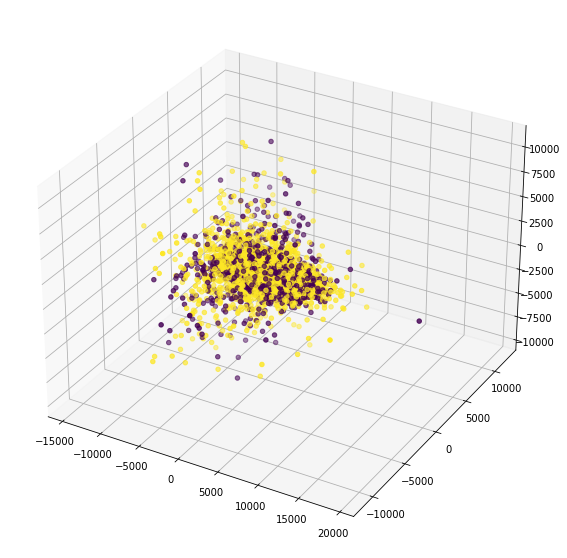

In [19]:
#Plotting the PCA 
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y)

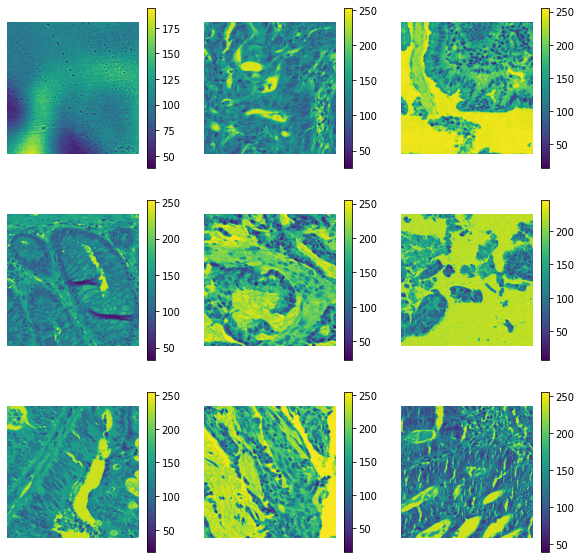

In [20]:
#Takes 9 random images from training set displaying MSS and MSIMUT images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.colorbar()
    #plt.title(class_names[labels[i]])
    plt.axis("off")


In [21]:
#Shape is 224(height)x(width)x1(RGB color channels == greyscale)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(128, 224, 224, 1)
(128, 1)


In [22]:
image_batch_numpy = image_batch.numpy()
labels_batch_numpy = labels_batch.numpy()
print('Training data: Minimum RGB value for batch: %.3f, Maximum RGB value: %.3f' % (image_batch_numpy.min(), image_batch_numpy.max()))


Training data: Minimum RGB value for batch: 5.000, Maximum RGB value: 255.000


****
**Normalizing the data**
****

In [23]:
rgb_normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_training_ds = train_ds.map(lambda x, y:(rgb_normalization(x), y))
image_batch, labels_batch = next(iter(normalized_training_ds))

In [24]:
print('Training data: Minimum RGB value for batch: %.3f, Maximum RGB value: %.3f' % (image_batch.numpy().min(), image_batch.numpy().max()))

Training data: Minimum RGB value for batch: 0.000, Maximum RGB value: 1.000


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
#Checking the shape of the labels and image data (X_train, y_train) to ensure everything is correct.
print("image_batch shape: ", image_batch.shape)
print("labels_batch shape: ", labels_batch.shape)


image_batch shape:  (128, 224, 224, 1)
labels_batch shape:  (128, 1)


## Training the model

In [27]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(width, height, 1)))
#Convolutions

#1
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
#Dropout to prevent overfitting
model.add(Dropout(0.25))

#2
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
#pooling layer to reduce amount of parameters and computation in the network
model.add(MaxPool2D())
model.add(Dropout(0.20))

#3
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20)
)

#4
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

#5                 
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.20))

#6
model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(MaxPool2D())
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 20)      200       
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 20)      3620      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 20)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 20)      3

In [28]:
#Tensorboard logging information
tensorboard = TensorBoard(
    log_dir = r'logs\{}'.format('cnn'),
    write_graph=True,
    write_grads=True,
    histogram_freq=1,
    write_images = True,
)

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
#Train the model
print('------------------------------------------------------------------------------------------------------------\n')
print('------------------------------------------Starting training...----------------------------------------------')
print('------------------------------------------------------------------------------------------------------------\n')
start = time()

trained_model = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

end = time()

time_elapsed = end - start

print('------------------------------------------------------------------------------------------------------------\n')
print('------------------------------------------Training Completed...---------------------------------------------')
print('------------------------------------------------------------------------------------------------------------\n')
print('\nTraining took {:.0f}h {:.0f}m {:.0f}s.'.format(time_elapsed//(60*60),
                                                        time_elapsed//60, 
                                                        time_elapsed % 60))

------------------------------------------------------------------------------------------------------------

------------------------------------------Starting training...----------------------------------------------
------------------------------------------------------------------------------------------------------------

Epoch 1/15
1202/1202 [==============================] - 380s 309ms/step - loss: 0.7174 - accuracy: 0.6007 - val_loss: 0.6758 - val_accuracy: 0.6098
Epoch 2/15
1202/1202 [==============================] - 497s 413ms/step - loss: 0.6702 - accuracy: 0.6099 - val_loss: 0.6713 - val_accuracy: 0.6098
Epoch 3/15
1202/1202 [==============================] - 484s 403ms/step - loss: 0.6695 - accuracy: 0.6099 - val_loss: 0.6709 - val_accuracy: 0.6098
Epoch 4/15
1202/1202 [==============================] - 481s 400ms/step - loss: 0.6695 - accuracy: 0.6099 - val_loss: 0.6696 - val_accuracy: 0.6098
Epoch 5/15
1202/1202 [==============================] - 480s 400ms/step - loss:

In [31]:
loss0, accuracy0 = model.evaluate(train_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1202/1202 [==============================] - 195s 162ms/step - loss: 0.6689 - accuracy: 0.6098
initial loss: 0.67
initial accuracy: 0.61


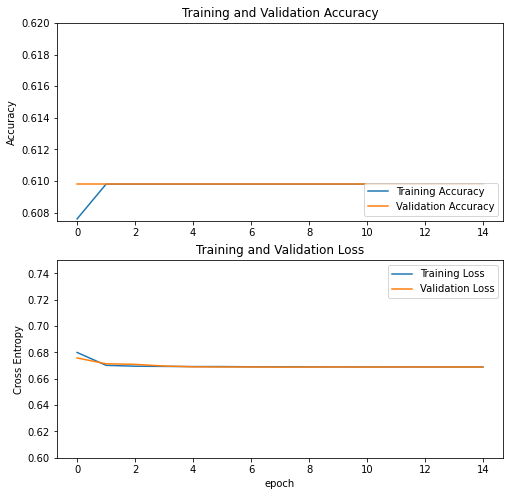

In [35]:
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']

loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.62])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.6,0.75])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()